# Gigs Senior Data Analyst Challenge

Welcome to the Gigs data analyst take-home challenge! This notebook will help you get started with analyzing our connectivity usage data.

## About the Data

You'll be working with three main datasets:
- **Usage Data**: Detailed usage per subscription period (~100K+ records)
- **Plan Events**: Plan configuration and pricing history
- **Projects**: Project metadata

## Setup Instructions

Run the cells below to set up your environment and load the data into DuckDB.

In [1]:
pip install uv

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Create virtual environment using the correct syntax
!uv venv

Using CPython 3.10.15 interpreter at: /usr/local/bin/python
Creating virtual environment at: .venv
? A virtual environment already exists at `.venv`. Do you want to replace it? [y/n] › yes

hint: Use the `--clear` flag or set `UV_VENV_CLEAR=1` to skip this prompt


In [3]:
# Activate virtual environment
!source .venv/bin/activate  
# On Windows: .venv\Scripts\activate

In [4]:

# Install dependencies (includes Jupyter, DuckDB, JupySQL, etc.)
!uv pip install -r /work/requirements.txt

Using Python 3.10.15 environment at: /root/venv
Audited 7 packages in 81ms


In [5]:
!python /work/setup.py

🔍 Gigs Data Analyst Challenge - Environment Verification
✅ uv is installed: uv 0.9.4
✅ Running in virtual environment: venv

📦 Checking required packages...
✅ duckdb: DuckDB Python client
✅ sql: JupySQL magic commands
✅ pandas: Pandas for data manipulation
✅ jupyter: Jupyter notebook
✅ duckdb_engine: DuckDB SQLAlchemy engine
✅ DuckDB version: 1.4.1
✅ DuckDB version supports required features
📁 Verifying data files...
❌ Missing: data/usage_by_subscription_period.csv
❌ Missing: data/plan_change_events.csv
❌ Missing: data/projects.csv

❌ Missing data files: ['data/usage_by_subscription_period.csv', 'data/plan_change_events.csv', 'data/projects.csv']
💡 Make sure you're in the data-analyst directory
🧪 Testing DuckDB integration...
✅ DuckDB basic test: Hello from DuckDB!
❌ Error reading data/usage_by_subscription_period.csv: IO Error: No files found that match the pattern "data/usage_by_subscription_period.csv"
📓 Verifying starter notebook...
❌ Starter notebook not found: analysis.ipynb
💡 Ma

In [6]:
# Import required libraries
import duckdb
import pandas as pd
from datetime import datetime, timedelta

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [7]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [8]:
!pip install sql==2022.4.0

In [9]:
# Load JupySQL extension and configure
%load_ext sql

# Configure JupySQL for better output
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

print("✅ JupySQL configured!")

✅ JupySQL configured!


In [10]:
# Connect to DuckDB
conn = duckdb.connect('gigs-analytics.db')
%sql conn --alias duckdb

print("✅ Connected to DuckDB database: gigs-analytics.db")

✅ Connected to DuckDB database: gigs-analytics.db


In [11]:
%%sql
-- Load data into DuckDB tables
CREATE OR REPLACE TABLE usage_data AS 
SELECT * FROM 'usage_by_subscription_period.csv';

CREATE OR REPLACE TABLE plan_events AS 
SELECT * FROM 'plan_change_events.csv';

CREATE OR REPLACE TABLE projects AS 
SELECT * FROM read_csv_auto('projects.csv', HEADER=TRUE);

,Count
0,3


In [12]:
%%sql
-- Verify data loading
select 
  'usage_data' as table_name, 
  count(*) as row_count,
  count(distinct subscription_id) as unique_subscriptions
from usage_data
union all
select 
  'plan_events' as table_name, 
  count(*) as row_count,
  count(distinct plan_id) as unique_plans
from plan_events
union all
select 
  'projects' as table_name, 
  count(*) as row_count,
  count(distinct project_id__hashed) as unique_projects
from projects;

,table_name,row_count,unique_subscriptions
0,usage_data,53565,8457
1,plan_events,209,36
2,projects,3,3


## Your Analysis Starts Here!

Now you have everything set up. Use the cells below to start your analysis.

### Tips:
- Use `%%sql` for multi-line SQL queries
- Use `%sql variable_name <<` to store results in a Python variable
- Combine SQL with Python/Pandas for advanced analysis
- Feel free to use any visualisation library you feel comfortable with

## How much data does a subscription typically consume?

--> On average, a subscription consumes 1,413 MB of data per period. However, this figure is heavily influenced by recently added outliers. A more representative measure of typical usage (50–80th percentile) falls between 134 and 807 MB per period.

--> Some subscriptions report zero usage, which further skews the results. Excluding these inactive subscriptions, typical usage rises to 218–1,052 MB per period.

In [13]:
%%sql

# Extract data on subscriptions and their usage - average and percentiles

SELECT DISTINCT
    'all subscriptions' AS segment,
    ROUND(PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY cumulative_data_usage_megabyte), 2) AS p50_data_usage,
    ROUND(PERCENTILE_CONT(0.8) WITHIN GROUP (ORDER BY cumulative_data_usage_megabyte), 2) AS p80_data_usage,
    ROUND(MEAN(cumulative_data_usage_megabyte), 2) AS average_data_usage
FROM usage_data

UNION ALL

SELECT DISTINCT
    'all subscriptions with usage' AS segment,
    ROUND(PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY cumulative_data_usage_megabyte), 2) AS p50_data_usage,
    ROUND(PERCENTILE_CONT(0.8) WITHIN GROUP (ORDER BY cumulative_data_usage_megabyte), 2) AS p80_data_usage,
    ROUND(MEAN(cumulative_data_usage_megabyte), 2) AS average_data_usage
FROM usage_data
WHERE cumulative_data_usage_megabyte > 0;

,segment,p50_data_usage,p80_data_usage,average_data_usage
0,all subscriptions,134.43,807.10,1413.41
1,all subscriptions with usage,218.39,1052.31,1793.81


### From this point forward, subscriptions longer than one month will be excluded to ensure comparability and focus on monthly trends. 22 subscriptions out of 52,716 were excluded.

In [14]:
%%sql

# Overview of subscription duration

SELECT 
    DATEDIFF('month', subscription_period_start, subscription_period_end) AS subscription_duration_months,
    COUNT(DISTINCT subscription_id::TEXT || subscription_period_number::TEXT) AS subscriptions
FROM usage_data
GROUP BY subscription_duration_months
ORDER BY subscription_duration_months;

,subscription_duration_months,subscriptions
0,0,787
1,1,52716
2,2,18
3,3,3
4,4,1



-- Retrieve monthly subscription usage data, including only subscriptions with a 1-month duration (or less)

In [15]:
%%sql 
subscription_usage <<
SELECT 
    DATE_TRUNC('month', reporting_date) AS reporting_month,
    DATEDIFF('month', subscription_period_start, subscription_period_end) AS subscription_duration_months,
    COUNT(DISTINCT subscription_id::TEXT || subscription_period_number::TEXT) AS subscriptions,
    AVG(cumulative_data_usage_megabyte) AS avg_cumulative_data_usage_megabyte
FROM usage_data
where DATEDIFF('month', subscription_period_start, subscription_period_end) <=1
GROUP BY 1, 2
ORDER BY 1, 2
;


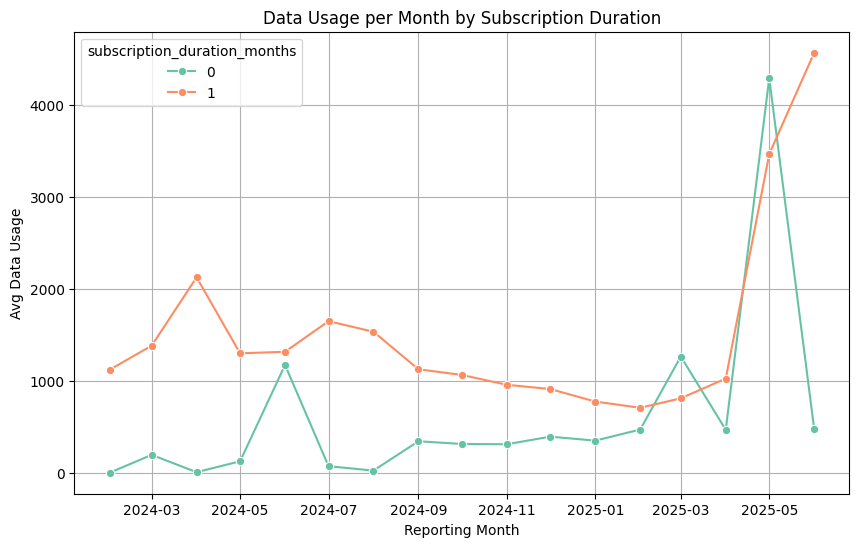

In [16]:
df = subscription_usage

# Plot the subscription data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df['reporting_month'] = pd.to_datetime(df['reporting_month'])

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x='reporting_month',
    y='avg_cumulative_data_usage_megabyte',
    hue='subscription_duration_months',
    palette='Set2',
    marker='o'
)
plt.title("Data Usage per Month by Subscription Duration")
plt.xlabel("Reporting Month")
plt.ylabel("Avg Data Usage")
plt.grid(True)
plt.show()

## How does usage look like at different plan data allowances?

Usage patterns vary across data plans: limited plans show relatively consistent usage, while unlimited plans exhibit high volatility.

In [17]:

%%sql 

-- Overview of the data allowances usage averages and percentiles

WITH usage_seqs AS (
    SELECT DISTINCT 
        a.*,
        COALESCE(b.data_allowance_mb::TEXT, 'unlimited') AS data_allowance_mb
    FROM usage_data a
    LEFT JOIN plan_events b 
        ON a.plan_id = b.plan_id 
    WHERE event_type = 'plan.published'
      AND DATEDIFF('month', subscription_period_start, subscription_period_end) <= 1
)

SELECT DISTINCT
    data_allowance_mb,
    COUNT(DISTINCT subscription_id::TEXT || subscription_period_number::TEXT) AS subscriptions,
    ROUND(AVG(cumulative_data_usage_megabyte), 2) AS avg_cumulative_data_usage_megabyte,
    ROUND(PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY cumulative_data_usage_megabyte), 2) AS p50_data_usage,
    ROUND(PERCENTILE_CONT(0.8) WITHIN GROUP (ORDER BY cumulative_data_usage_megabyte), 2) AS p80_data_usage
FROM usage_seqs
GROUP BY data_allowance_mb
ORDER BY avg_cumulative_data_usage_megabyte;

,data_allowance_mb,subscriptions,avg_cumulative_data_usage_megabyte,p50_data_usage,p80_data_usage
0,1000.0,44548,365.85,114.09,486.81
1,5000.0,3315,1694.69,358.99,3153.53
2,0.0,68,3766.83,198.39,2639.46
3,unlimited,5545,9635.82,1876.33,14102.72


#  Extract data to plot monthly usages

In [18]:
%%sql 
data_plan_usage <<
WITH usage_seq AS (
    SELECT DISTINCT 
        a.*,
        COALESCE(b.data_allowance_mb::TEXT, 'unlimited') AS data_allowance_mb
    FROM usage_data a
    LEFT JOIN plan_events b 
        ON a.plan_id = b.plan_id
    WHERE event_type = 'plan.published'
      AND DATEDIFF('month', subscription_period_start, subscription_period_end) <= 1
)

SELECT DISTINCT
    DATE_TRUNC('month', reporting_date) AS reporting_month,
    data_allowance_mb,
    COUNT(DISTINCT subscription_id::TEXT || subscription_period_number::TEXT) AS subscriptions,
    AVG(cumulative_data_usage_megabyte) AS avg_cumulative_data_usage_megabyte
FROM usage_seq
GROUP BY reporting_month, data_allowance_mb;

In [54]:
%%sql 

-- Overview of th eplans per organization

WITH usage_seq AS (
    SELECT DISTINCT 
        a.*,
        COALESCE(b.data_allowance_mb::TEXT, 'unlimited') AS data_allowance_mb
    FROM usage_data a
    LEFT JOIN plan_events b 
        ON a.plan_id = b.plan_id
    WHERE event_type = 'plan.published'
      AND DATEDIFF('month', subscription_period_start, subscription_period_end) <= 1
)

SELECT DISTINCT
    data_allowance_mb,
    organization_name,
    COUNT(DISTINCT subscription_id::TEXT || subscription_period_number::TEXT) AS subscriptions,
    AVG(cumulative_data_usage_megabyte) AS avg_cumulative_data_usage_megabyte
FROM usage_seq
left join projects using (project_id__hashed)
GROUP BY  data_allowance_mb,organization_name
ORDER BY organization_name,data_allowance_mb;

,data_allowance_mb,organization_name,subscriptions,avg_cumulative_data_usage_megabyte
0,1000.0,ACME Phone,44548,365.845145
1,5000.0,ACME Phone,2715,1749.114219
2,unlimited,ACME Phone,3916,8648.477499
3,0.0,People Mobile,68,3766.828288
4,5000.0,People Mobile,140,2035.178715
5,unlimited,People Mobile,615,26718.603068
6,5000.0,SmartDevices Inc.,460,1269.136147
7,unlimited,SmartDevices Inc.,1014,3093.849548


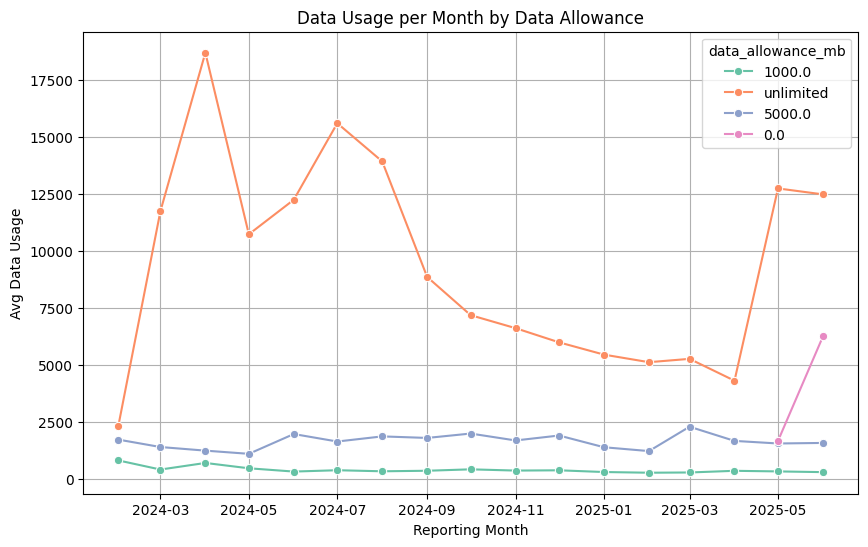

In [57]:
# PLot monthly trends

df = data_plan_usage
df['reporting_month'] = pd.to_datetime(df['reporting_month'])

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x='reporting_month',
    y='avg_cumulative_data_usage_megabyte',
    hue='data_allowance_mb',
    palette='Set2',
    marker='o'
)
plt.title("Data Usage per Month by Data Allowance")
plt.xlabel("Reporting Month")
plt.ylabel("Avg Data Usage")
plt.grid(True)
plt.show()

## Do subscriptions typically consume consistent amounts of data throughout their lifetime?

No, subscriptions generally consume less data during their final period, just before churning (or the last reporting month). Most multi-period subscriptions show higher usage in the first few periods, which gradually declines over time until churn (or the last reporting month).

When splitting by churn status, retained subscriptions consistently use more data in the current period compared to those that churn. This suggests that data usage could serve as a potential predictor of churn.

Disclaimer: Churned subscription is a subscription with no following reporting period

-- extract data and cohort on total subscriptions periods per subscription

In [60]:
%%sql 
usage_sequence <<
WITH usage_seq AS (
    SELECT 
        *,
        MAX(subscription_period_number) OVER (PARTITION BY subscription_id) AS sub_periods
    FROM usage_data
    WHERE DATEDIFF('month', subscription_period_start, subscription_period_end) <= 1
)

SELECT DISTINCT
    sub_periods,
    subscription_period_number,
    COUNT(DISTINCT subscription_id::TEXT || subscription_period_number::TEXT) AS subscriptions,
    AVG(cumulative_data_usage_megabyte) AS avg_cumulative_data_usage_megabyte
FROM usage_seq
GROUP BY sub_periods, subscription_period_number;

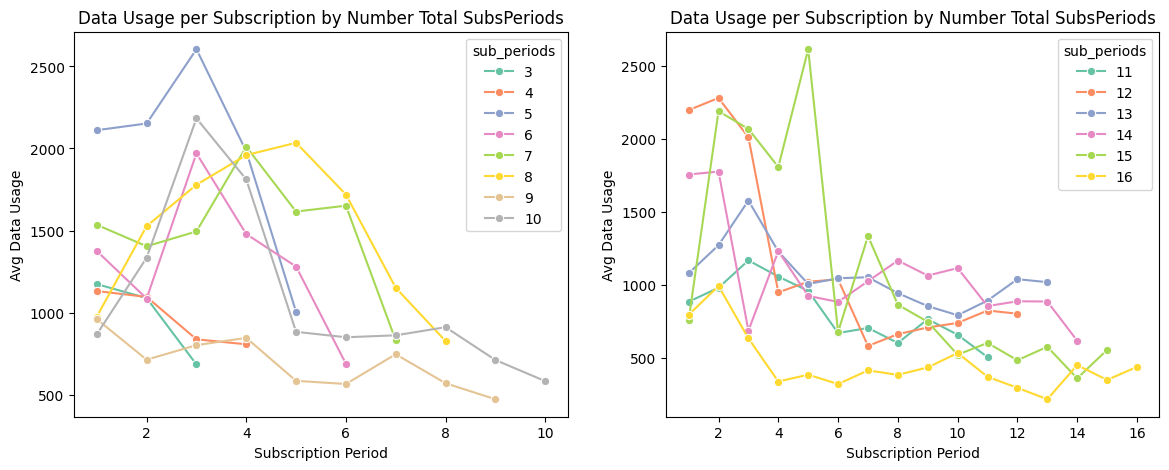

In [63]:
# Create 1 row, 2 columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

# Check if 'sub_periods' column exists in usage_sequence DataFrame
if 'sub_periods' in usage_sequence.columns:
    df = usage_sequence[usage_sequence['sub_periods'] <= 10]
    df = df[df['sub_periods'] > 2]
    df_1 = usage_sequence[usage_sequence['sub_periods'] > 10]

    sns.lineplot(
        data=df,
        x='subscription_period_number',
        y='avg_cumulative_data_usage_megabyte',
        hue='sub_periods',
        palette='Set2',
        marker='o',
        ax=axes[0]
    )
    axes[0].set_title("Data Usage per Subscription by Number Total SubsPeriods")
    axes[0].set_xlabel("Subscription Period")
    axes[0].set_ylabel("Avg Data Usage")

    sns.lineplot(
        data=df_1,
        x='subscription_period_number',
        y='avg_cumulative_data_usage_megabyte',
        hue='sub_periods',
        palette='Set2',
        marker='o',
        ax=axes[1]
    )
    axes[1].set_title("Data Usage per Subscription by Number Total SubsPeriods")
    axes[1].set_xlabel("Subscription Period")
    axes[1].set_ylabel("Avg Data Usage")
else:
    print("Error: 'sub_periods' column not found in usage_sequence DataFrame.")

Define Churned subscription as a subscription with no following reporting period

In [66]:
%%sql churn <<
with usage_seq as (
select * ,
MAX(subscription_period_end) OVER (PARTITION by subscription_id) AS max_subscriptions_end
from usage_data
where DATEDIFF('month', subscription_period_start, subscription_period_end) <=1
)
SELECT DISTINCT
    DATE_TRUNC('month', reporting_date) AS reporting_month,
    case when DATE_TRUNC('month', reporting_date) = DATE_TRUNC('month', max_subscriptions_end) then 'churn' else 'retained' end as retention,
    COUNT(DISTINCT subscription_id::TEXT || subscription_period_number::TEXT) AS subscriptions,
    AVG(cumulative_data_usage_megabyte) AS avg_cumulative_data_usage_megabyte,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY cumulative_data_usage_megabyte) AS p50_usage
FROM usage_seq
group by 1,2
;

Text(0, 0.5, 'Avg Data Usage')

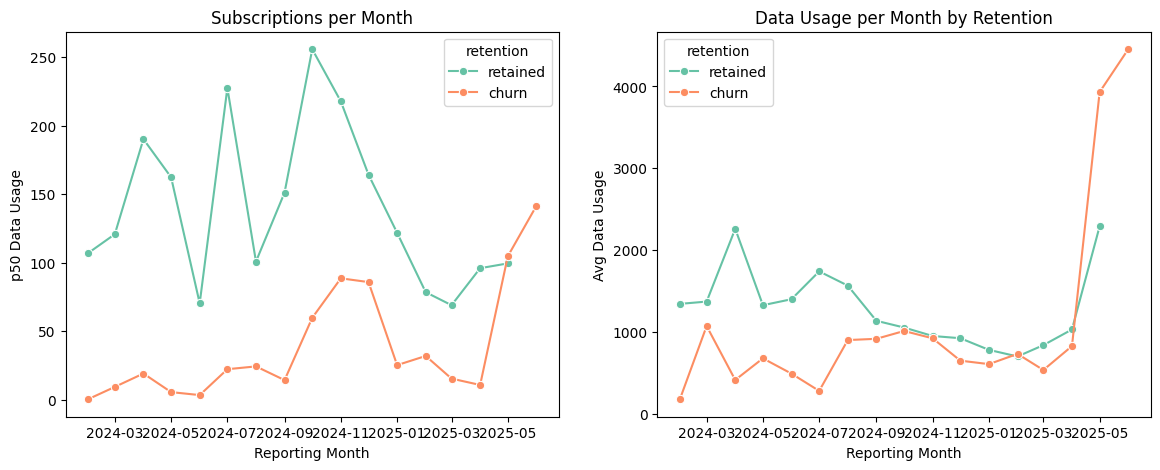

In [69]:
# Create 1 row, 2 columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns



df = churn


df['reporting_month'] = pd.to_datetime(df['reporting_month'])

sns.lineplot(
    data=df,
    x='reporting_month',
    y='p50_usage',
    hue='retention',
    palette='Set2',
    marker='o',
    ax=axes[0]
)
axes[0].set_title("Subscriptions per Month")

axes[0].set_xlabel("Reporting Month")
axes[0].set_ylabel("p50 Data Usage")


sns.lineplot(
    data=df,
    x='reporting_month',
    y='avg_cumulative_data_usage_megabyte',
    hue='retention',
    palette='Set2',
    marker='o',
    ax=axes[1]
)
axes[1].set_title("Data Usage per Month by Retention")
axes[1].set_xlabel("Reporting Month")
axes[1].set_ylabel("Avg Data Usage")



## Compare the retention pattern for the most recently launched project versus the two older ones.

Most recently launched project: People Mobile (P M)

Launch Date: 1st April 2025
Latest Reporting Date: 16th June 2025

Since only two subscription periods have been recorded for People Mobile to date, we will focus on comparing only the first two subscription periods across all projects.

Disclaimer: Churn Definition

- Churn is defined as subscriptions with no sequential reporting period.

- In most cases, the next reporting period is not yet completed, so usage data is unavailable. Last month of usage is biased.

- Ideally, we would use renewal data, but in the absence of this, reporting periods are used as a proxy.

## Key Observations

Long Time to market

- People Mobile has a very high proportion of not-yet-reported usage periods, resulting in a high churn rate for the first subscription period (see disclaimer). We need a proper churn data in order to determine churn rate and retention

- Similar patterns are observed in Smart Devices (launched 4th March 2025).

- Majority of the subscriptions are activated in May - 1 month after the launch date. 

- Hypothesis: Onboarding may be unclear, and users might struggle to set up their subscriptions properly.

High  Data Usage

- People Mobile show high data usage in the first subscription period with majority of the data plans being unlimited.

- In contrast, ACME (launched January 2024) and Smart Devices exhibits relatively low usage, suggesting that newly launched projects may have more complex needs and may be overwhelmed during initial onboarding.

## Additional Questions & Data Points

Churn Reasons & Customer Feedback

- Are trial plans prevalent, and do users fully understand them?

- Preliminary evidence suggests trial-and-error behavior in plan selection and some unassigned plans.

Subscription Types

- Are seasonal and constant subscriptions differentiated?

- These should be treated separately, as they have different usage patterns and added value.

Monthly Trends & Time Consistency

- Do users have consistent usage or occasional spikes?

- Since plans are based on monthly or 30-day periods, analyzing monthly usage alongside churn, expansion, and contraction is important.

- We need daily reporting as additional push strategies could be implemented when subscriptions approach their limits.

User-Based Deep Dive

- Are we losing users or just subscriptions?

- Because users can have multiple subscriptions, focusing on user retention is key to understanding needs and providing guidance on better plan definitions.

In [72]:
%%sql 
WITH usage_seq AS (
    SELECT *,
           MAX(subscription_period_end) OVER (PARTITION BY subscription_id) AS max_subscriptions_end
    FROM usage_data
    LEFT JOIN projects USING (project_id__hashed)
)

SELECT DISTINCT
       organization_name,
       COUNT(DISTINCT subscription_id) AS subscriptions,
       MIN(subscription_period_start) AS first_subscription,
       MAX(subscription_period_number) AS max_subscription_period_number
FROM usage_seq
GROUP BY organization_name
ORDER BY first_subscription DESC;

,organization_name,subscriptions,first_subscription,max_subscription_period_number
0,People Mobile,734,2025-04-01,2
1,SmartDevices Inc.,986,2025-03-04,4
2,ACME Phone,6737,2024-01-21,16


In [90]:
%%sql monthly_retention_data <<
WITH usage_seq AS (
    SELECT *,
           MAX(subscription_period_end) OVER (PARTITION BY subscription_id) AS max_subscriptions_end
    FROM usage_data
    LEFT JOIN projects USING (project_id__hashed)
    WHERE DATEDIFF('month', subscription_period_start, subscription_period_end) <= 1
      AND subscription_period_number IN (1, 2, 3)
)

SELECT DISTINCT
       DATE_TRUNC('month', reporting_date) AS reporting_month,
       CASE 
           WHEN organization_name = 'ACME Phone' THEN 'ACME'
           WHEN organization_name = 'People Mobile' THEN 'P M'
           WHEN organization_name = 'SmartDevices Inc.' THEN 'Sm Dev'
       END AS org_name,
       COUNT(DISTINCT subscription_id) AS subscriptions,
       COUNT(DISTINCT CASE 
                          WHEN DATE_TRUNC('month', reporting_date) = DATE_TRUNC('month', max_subscriptions_end) 
                          THEN subscription_id 
                      END) AS churn_subscriptions,
       COUNT(DISTINCT CASE 
                          WHEN DATE_TRUNC('month', reporting_date) <> DATE_TRUNC('month', max_subscriptions_end) 
                          THEN subscription_id 
                      END) AS retained_subscriptions,
       AVG(cumulative_data_usage_megabyte) AS avg_cumulative_data_usage_megabyte
FROM usage_seq
GROUP BY 1, 2;

In [93]:

# Add churn rate column
monthly_retention_data['churn_rate'] = (
    (monthly_retention_data['churn_subscriptions'] / (monthly_retention_data['churn_subscriptions'] + monthly_retention_data['retained_subscriptions']) )* 100
).round(2)

monthly_retention_data['month_sequence'] = (
    monthly_retention_data.sort_values(['org_name', 'reporting_month'])
      .groupby('org_name')
      .cumcount() + 1
)

# Add total subscriptions
monthly_retention_data['subscriptions'] = monthly_retention_data['churn_subscriptions'] + monthly_retention_data['retained_subscriptions']

monthly_retention_data.reset_index(inplace=True)

Text(0, 0.5, 'Subscriptions')

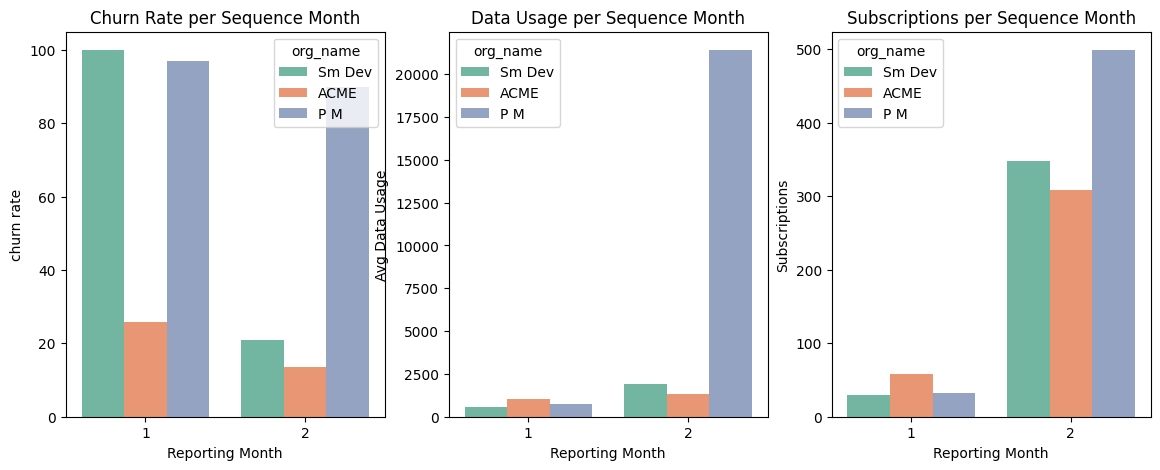

In [96]:
df = monthly_retention_data[monthly_retention_data['month_sequence'].isin([1, 2])]

# Create 1 row, 2 columns of subplots
fig, axes = plt.subplots(1, 3, figsize=(14, 5))  # 1 row, 2 columns


sns.barplot(
    data=df,
    x='month_sequence',
    y='churn_rate',
    hue='org_name',
    palette='Set2',
    ax=axes[0]
)
axes[0].set_title("Churn Rate per Sequence Month")

axes[0].set_xlabel("Reporting Month")
axes[0].set_ylabel("churn rate")


sns.barplot(
    data=df,
    x='month_sequence',
    y='avg_cumulative_data_usage_megabyte',
    hue='org_name',
    palette='Set2',
    ax=axes[1]
)
axes[1].set_title("Data Usage per Sequence Month")
axes[1].set_xlabel("Reporting Month")
axes[1].set_ylabel("Avg Data Usage")

sns.barplot(
    data=df,
    x='month_sequence',
    y='subscriptions',
    hue='org_name',
    palette='Set2',
    ax=axes[2]
)
axes[2].set_title("Subscriptions per Sequence Month")
axes[2].set_xlabel("Reporting Month")
axes[2].set_ylabel("Subscriptions")

In [102]:
%%sql subsc_retention_data <<
WITH usage_seq AS (
    SELECT *,
           MAX(subscription_period_end) OVER (PARTITION BY subscription_id) AS max_subscriptions_end
    FROM usage_data
    LEFT JOIN projects USING (project_id__hashed)
    WHERE DATEDIFF('month', subscription_period_start, subscription_period_end) <= 1
      AND subscription_period_number IN (1, 2, 3)
)

SELECT DISTINCT
       subscription_period_number,
       CASE 
           WHEN organization_name = 'ACME Phone' THEN 'ACME'
           WHEN organization_name = 'People Mobile' THEN 'P M'
           WHEN organization_name = 'SmartDevices Inc.' THEN 'Sm Dev'
       END AS org_name,
       COUNT(DISTINCT subscription_id) AS subscriptions,
       COUNT(DISTINCT CASE 
                          WHEN DATE_TRUNC('month', reporting_date) = DATE_TRUNC('month', max_subscriptions_end) 
                          THEN subscription_id 
                      END) AS churn_subscriptions,
       COUNT(DISTINCT CASE 
                          WHEN DATE_TRUNC('month', reporting_date) <> DATE_TRUNC('month', max_subscriptions_end) 
                          THEN subscription_id 
                      END) AS retained_subscriptions,
       AVG(cumulative_data_usage_megabyte) AS avg_cumulative_data_usage_megabyte
FROM usage_seq
GROUP BY 1, 2;

Text(0, 0.5, 'Subscriptions')

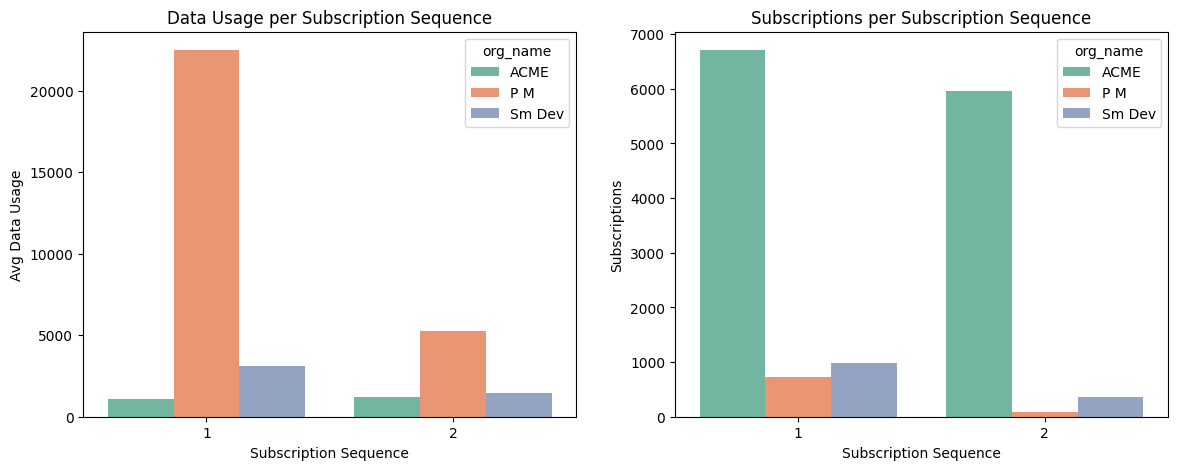

In [111]:
df = subsc_retention_data[subsc_retention_data['subscription_period_number'].isin([1, 2])]

# Create 1 row, 2 columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns



sns.barplot(
    data=df,
    x='subscription_period_number',
    y='avg_cumulative_data_usage_megabyte',
    hue='org_name',
    palette='Set2',
    ax=axes[0]
)
axes[0].set_title("Data Usage per Subscription Sequence")
axes[0].set_xlabel("Subscription Sequence")
axes[0].set_ylabel("Avg Data Usage")

sns.barplot(
    data=df,
    x='subscription_period_number',
    y='subscriptions',
    hue='org_name',
    palette='Set2',
    ax=axes[1]
)
axes[1].set_title("Subscriptions per Subscription Sequence")
axes[1].set_xlabel("Subscription Sequence")
axes[1].set_ylabel("Subscriptions")

# Documentation of finding

1. Typical Usage

- Average subscription consumes ~1.4 GB per period, but typical usage ranges 134–807 MB (or 218–1,052 MB excluding zero-usage subscriptions).

2. Usage Patterns by Plan

- Limited data plans show consistent usage.

- Unlimited plans exhibit high variability, indicating differing user needs.

3. Subscription Lifecycle

- Usage tends to be higher in early periods and declines toward the end of a subscription, especially for churned users.

- Retained subscriptions consistently show higher period usage, suggesting data consumption could be a predictive signal for churn.

4. New vs. Established Projects

- New projects (People Mobile): Slow but high early usage, likely reflecting onboarding complexity and short-term user needs.

- Established project (ACME): Lower, stable usage over time, indicating more predictable consumption.

5. Key Observations

- Onboarding complexity may drive early churn and low initial usage.

- Trial plans and unclear plan settings contribute to user confusion.

- Seasonal or high-demand use cases require differentiated plan strategies.

6. Recommendations

- Review and clarify onboarding processes for new projects.

- Differentiate between seasonal and constant subscriptions in reporting and strategy.

- Monitor usage trends for early churn detection and targeted retention efforts.

- Focus on user-level retention metrics in addition to subscription-level metrics to refine plan offerings.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1cb4f8a3-e1f3-48b0-bf71-de08d3ef2b1c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>